In [1]:
%run ../scripts/notebook_settings_lean.py
import tskit

In [2]:
ts = tskit.load("../results/All_Samples_relate/chromhapX.trees")

In [ ]:
ts

In [13]:
# Version which counts number of samples, and notes both the first coalescence and when 50 % has coalesced.
def coalescence_ordering(tree, IDs, sample_counts):
    df_list = []
    for i in IDs:
        pop_list = []
        gen_list = []
        coal_counts = {}
        for p in sample_counts.index:
            coal_counts[p] = 0
        current_node = i
        while tree.depth(current_node) > 0:
            # Find parent node
            parent_node = tree.parent(current_node)
            # Determine children, and then pick alternate
            # cannot find a method for this, so I use an explicit if/else
            children = tree.children(parent_node)
            if current_node == children[0]:
                alt_node = children[1]
            else:
                alt_node = children[0]
            # Determine which populations are present under the alternate node
            alt_samples = pd.Series([x for x in tree.samples(alt_node)])
            alt_sample_counts = alt_samples.map(i_mapping).value_counts()
            for p in alt_sample_counts.index:
                coal_counts[p] += alt_sample_counts[p]
            # If pop is not already added to list, add pop and note coal time
            for p in alt_sample_counts.index:
                if p  not in pop_list and coal_counts[p] > sample_counts[p]/2:
                    pop_list.append(p)
                    gen_list.append(tree.time(current_node))
            current_node = parent_node
        d = {"ID": i, "sites": tree.num_sites, "span": tree.span, "start": tree.interval[0]}
        for i in range(len(pop_list)):
            d["coal_{}".format(i)] = pop_list[i]
        for i in range(len(gen_list)):
            d["coal_date_{}".format(i)] = gen_list[i]
        df_list.append(pd.DataFrame(d, index=[i]))
    return pd.concat(df_list)

In [14]:
#ts_subset = ts.keep_intervals([[10000000, 30000000]])
#ts_subset
ts

In [15]:
ts.individuals()

In [16]:
poplabels = pd.read_csv("../data/pops/haploid_x_8cluster.sample", sep=" ",
                        names=["ID", "POP", "GROUP", "SEX"], header=0)

In [17]:
poplabels_eth = poplabels.loc[poplabels.GROUP == "Ethiopian_Olive"].reset_index(drop=True)

In [18]:
i_mapping = {}
for i, row in poplabels_eth.iterrows():
    i_mapping[i] = row.GROUP
poplabel_counts = poplabels["GROUP"].value_counts().to_dict()
highest_ID = poplabels_eth.index.max()+1

In [8]:
c = 0
ID_list = list(i_mapping.keys())
sample_counts = poplabels_eth["GROUP"].value_counts()
df_list = []
for tree in ts.trees():
    df = coalescence_ordering(tree, ID_list, sample_counts)
    if c % 1000 == 0:
        print(c)
    c += 1
    df_list.append(df)
test_df = pd.concat(df_list)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [9]:
test_df = test_df.dropna()

In [10]:
median_df = test_df.groupby(["start", "coal_0"]).median()

<Axes: xlabel='start', ylabel='coal_date_0'>

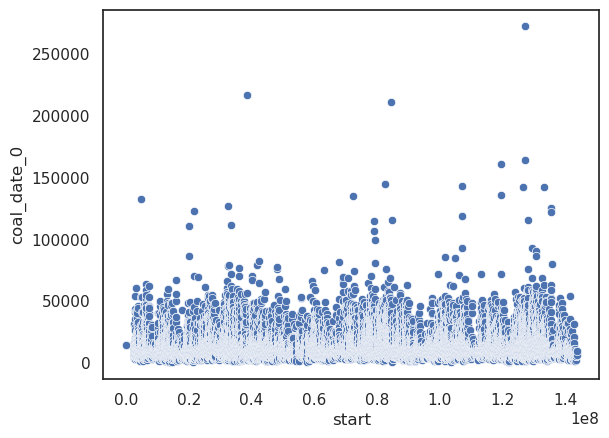

In [11]:
sns.scatterplot(data=median_df, x="start", y="coal_date_0")

In [12]:
median_df

,,ID,sites,span,coal_date_0
start,coal_0,,,,
0.0,Ethiopian_Olive,16.0,2.0,2501401.0,14629.491211
2501401.0,Ethiopian_Olive,16.0,15.0,14235.0,4091.279053
2515636.0,Ethiopian_Olive,16.0,14.0,7804.0,5600.466797
2523440.0,Ethiopian_Olive,16.0,45.0,6930.0,13731.026367
2530370.0,Ethiopian_Olive,16.0,8.0,867.0,11482.481445
...,...,...,...,...,...
143562953.0,Ethiopian_Olive,16.0,11.0,8228.0,9946.495117
143571181.0,Ethiopian_Olive,16.0,58.0,67052.0,7055.288574
143638233.0,Ethiopian_Olive,16.0,9.0,13502.0,8188.390625


In [13]:
pos_list, coal_list = [], []
window_size = 250000
m_df = median_df.reset_index()


for i in range(0, int(m_df.start.iloc[-1]), window_size):
    sub_df = m_df.loc[(m_df.start >= i) & (m_df.start < i+window_size)]
    if len(sub_df) > 1:
        m = sub_df.coal_date_0.mean()
        pos_list.append(i), coal_list.append(m)
    else:
        pos_list.append(np.NaN), coal_list.append(0)

<Axes: >

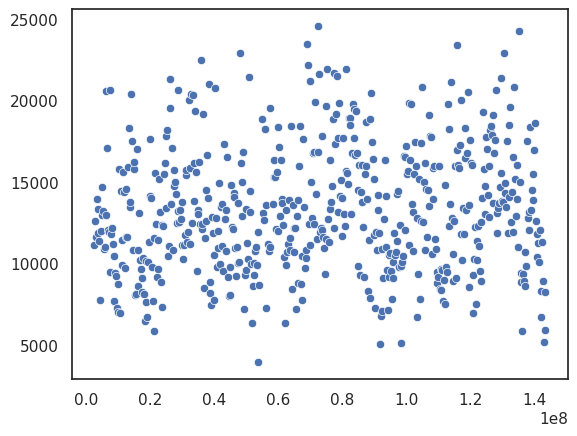

In [14]:
sns.scatterplot(x=pos_list, y=coal_list)

In [15]:
coal_df = pd.DataFrame({"pos": pos_list, "coal": coal_list})

<Axes: xlabel='pos', ylabel='coal'>

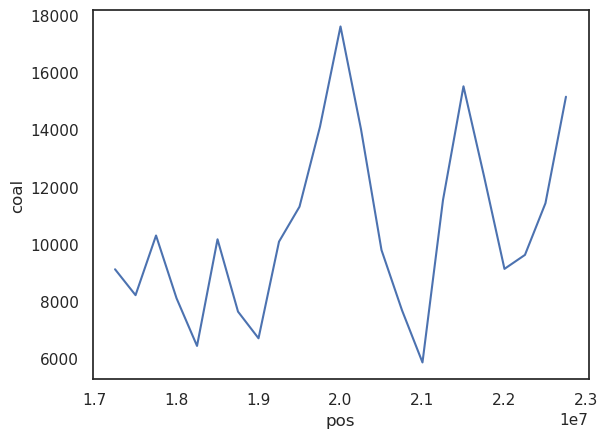

In [20]:
sns.lineplot(data=coal_df.loc[(coal_df.pos > 17000000) & 
                                 (coal_df.pos < 23000000)], x="pos", y="coal")